## 6-3. 励起状態の探索手法 (subspace-search variational quantum eigensolver)

5-1節で説明した通り、variational quantum eigensolver (VQE) は量子系の**基底状態**を探すためのアルゴリズムである。基底状態は様々な物質の性質を決める重要な状態であるが、光応答など、**励起状態** を使わなければ記述が困難な現象も存在する。

そこで、量子コンピュータ上に励起状態の波動関数を作り出すためのアルゴリズムも盛んに研究されている。その中でも、ここでは 2018 年に提案された新しい手法である部分空間探索 VQE (Subspace-Search VQE, SSVQE) [1] を紹介したい。

### アルゴリズム

SSVQE の手続きを以下に示す。

1. 互いに直交する $k$ 個の初期状態 $\{|\varphi_i\rangle\}_{i=0}^{k-1}$ を準備する。
2. そのそれぞれについて、適当な量子回路 $U(\theta)$ を作用させ試行状態 $\{|\psi_i(\theta)\rangle \}_{i=0}^{k-1}$ を生成する。（注：$|\psi_i(\theta)\rangle = U(\theta)|\varphi_i\rangle$である）
3. コスト関数 $L(\theta) = \sum_i w_i \langle\psi_i(\theta)|H|\psi_i(\theta)\rangle$ を最小化するように $\theta$ を調整する。ここで $w_i$ は正かつ $i>j$ のとき $w_i<w_j$ となるように選ぶ。

$U(\theta)$ が十分な表現能力を持っているとき、収束した $\theta$ において $|\psi_i\rangle$ は $i$ 番目の励起状態となる。これは、ハミルトニアンの第 $i$ 励起状態を $|E_i\rangle$ とするとき。コスト関数の大域的な最小点が $|\psi_i\rangle = |E_i\rangle$ となっているからである。（詳細は原論文[1]を参照のこと）


以下では、SSVQE を Qulacs を用いてシミュレートする例を示す。

### SSVQE の実装

水素分子の基底状態と第一励起状態を探索する SSVQE を実装する。水素分子を `sto-3g` の minimal basis set で扱うと、4 qubit のハミルトニアンが得られる。そこで SSVQE に必要な互いに直交する初期状態 $\{|\varphi_i\rangle\}_{i=0}^{1}$ として、一つの qubit がフリップした $|0000\rangle$ と $|0001\rangle$ の二つを用いる。

#### ハミルトニアンを作る

前回と同様の手順で、ハミルトニアンを PySCF + OpenFermion によって計算する。ただし SSVQE では励起状態も問題となるので、`scipy.sparse.linalg.eigsh` を用いて励起状態の厳密解を求めておく。

In [ ]:
## Google Colaboratory上で実行する場合バグを回避するためscipyをダウングレード
!pip install scipy==1.2.1

In [ ]:
## 各種ライブラリがインストールされていない場合は実行してください
## Google Colaboratory上で実行する場合'You must restart the runtime in order to use newly installed versions.'と出ますが無視してください。
## runtimeを再開するとクラッシュします。
!pip install qulacs pyscf openfermion openfermionpyscf

In [4]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.transforms import get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

In [5]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
hamiltonian_matrix = get_sparse_operator(jw_hamiltonian)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA")
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

#### ansatz を構成する

Qulacs 上で量子回路を構成する。前回と同様に、量子回路は超伝導量子ビットによる実験 (A. Kandala et. al., Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets, Nature **549**, 242–246) で用いられたものを模したものを使用する。


In [6]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [7]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    circuit.add_gate(RY(0, theta_list[-2]))
    circuit.add_gate(RZ(0, theta_list[-1]))
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
    
    return circuit

#### SSVQE のコスト関数を定義する

In [8]:
def get_exp(state, theta_list):
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #量子回路を構成
    circuit.update_quantum_state(state) #量子回路を状態に作用
    return qulacs_hamiltonian.get_expectation_value(state)

def cost(theta_list):
    state0 = QuantumState(n_qubit) #|00000> を準備
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #|00001> を準備
    return get_exp(state0, theta_list)+0.5*get_exp(state1, theta_list)
    
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
cost(init_theta_list)

0.211562756558141

#### SSVQE を実行する

準備ができたので、SSVQE を実行する。最適化には scipy に実装されている BFGS 法を用い、初期パラメータはランダムに選ぶ。数十秒で終わるはずである。

In [10]:
exp_history0 = []
exp_history1 = []
def callback(theta_list):
    state0 = QuantumState(n_qubit) #|0000> を準備
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #|0001> を準備
    exp_history0.append(get_exp(state0, theta_list))
    exp_history1.append(get_exp(state1, theta_list))
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=callback)

実行結果をプロットしてみると、正しい解に収束していることが見て取れる。

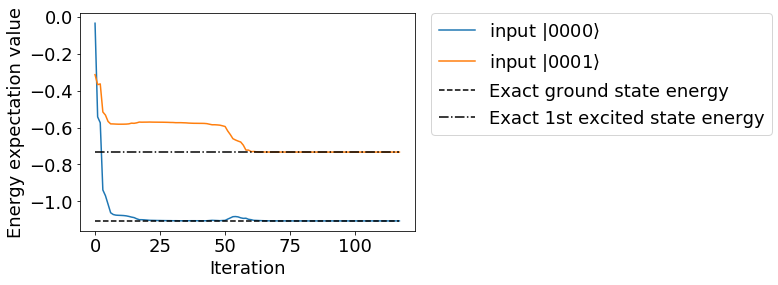

In [20]:
plt.rcParams["font.size"] = 18
plt.plot(exp_history0, label=r"input $|0000\rangle$")
plt.plot(exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history0)), [molecule.fci_energy]*len(exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history1)), [eigval[1]]*len(exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

### 参考文献
[1] Ken M Nakanishi, Kosuke Mitarai, and Keisuke Fujii, “Subspace-search variational quantum eigensolver for excited states”, [arXiv:1810.09434](https://arxiv.org/abs/1810.09434)